In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import transformers
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel

np.random.seed(0)
torch.manual_seed(0)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [56]:
df = pd.read_csv('data/toxic_comments.csv').drop(columns='id')
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### what's the approximate word count?

In [57]:
word_counts = df.comment_text.apply(lambda x: len(x.split()))

<AxesSubplot:xlabel='comment_text', ylabel='Count'>

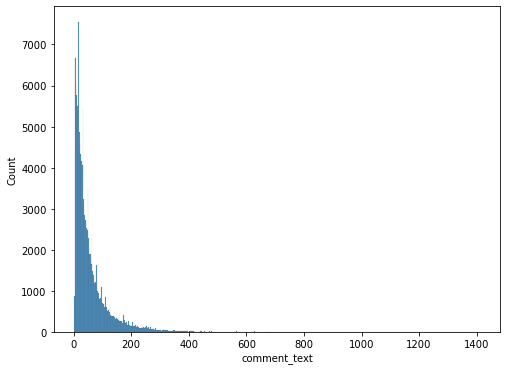

In [58]:
plt.figure(figsize=(8, 6))
sns.histplot(x = word_counts)

In [5]:
word_counts.describe()
# We'll take the median (36) as our max sequence length

count    159571.000000
mean         67.273527
std          99.230702
min           1.000000
25%          17.000000
50%          36.000000
75%          75.000000
max        1411.000000
Name: comment_text, dtype: float64

### Distribution of targets

#### subsampling, train and test sets

In [59]:
sample = df.sample(500).reset_index(drop=True)

#### Custom Dataset and DataLoader

In [60]:
max_len = 36
batch_size = 32
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [61]:
# token ids needed to retrieve embeddings
inputs = tokenizer.encode_plus(
            sample.comment_text[0],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
inputs

{'input_ids': [101, 1000, 1045, 4033, 1005, 1056, 11498, 8458, 23797, 2094, 2017, 2012, 2035, 1010, 5639, 1012, 2017, 10865, 2008, 21393, 3522, 4216, 2000, 2216, 1000, 1000, 2092, 2058, 1017, 2086, 2214, 1000, 1000, 2003, 1000, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [63]:
class ToxCOmmentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.df = df
        self.comments = df.comment_text
        self.targets = df.drop(columns='comment_text').values.tolist()


    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        comment = self.comments[index]
        targets = self.targets[index]

        inputs = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )

        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"] 

        return {
                'ids': torch.tensor(ids, dtype=torch.long),
                'mask': torch.tensor(mask, dtype=torch.long),
                'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
                'targets': torch.tensor(targets, dtype=torch.float)
            }

In [64]:
train_data, test_data = train_test_split(sample, test_size=0.2)
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)
train_data.shape, test_data.shape

((400, 7), (100, 7))

In [65]:
train_set = ToxCOmmentDataset(train_data, tokenizer, max_len)
test_set = ToxCOmmentDataset(test_data, tokenizer, max_len)

In [67]:
print(len(train_set))
train_set[0]

400


{'ids': tensor([  101,  1000,  2089,  2268,  3531,  2079,  2025,  3158,  9305,  4697,
          5530,  1010,  2004,  2017,  2106,  2007,  2023, 10086,  2000, 11268,
          7088,  3723,  1012,  2065,  2017,  3613,  2000,  2079,  2061,  1010,
          2017,  2097,  2022,  8534,  2013,   102]),
 'mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'targets': tensor([0., 0., 0., 0., 0., 0.])}

In [68]:
train_loader = DataLoader(train_set, batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size, shuffle=False, drop_last=True)

In [69]:
print(len(train_loader))
iter(train_loader).next()['ids'].shape, iter(train_loader).next()['targets'].shape

12


(torch.Size([32, 36]), torch.Size([32, 6]))

### Model architecture

In [71]:
bert_model = BertModel.from_pretrained('bert-base-uncased')

class Classifier(nn.Module):
    def __init__(self, bert_model):
        super(Classifier, self).__init__()
        self.emb = bert_model # creating the embeddings (with emb dim == 768)
        self.fc = nn.Linear(768, 6)
    
    def forward(self, ids, mask, token_type_ids):
        output = self.emb(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output = output.pooler_output
        output = self.fc(output)
        return output

model = Classifier(bert_model)
model

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Classifier(
  (emb): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  

In [72]:
x_y = iter(train_loader).next()


In [73]:
output = bert_model(x_y['ids'], attention_mask = x_y['mask'], token_type_ids = x_y["token_type_ids"])

In [74]:
output.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [75]:
# Test model
y_true = x_y['targets']
logits = model(x_y['ids'], x_y['mask'], x_y["token_type_ids"])
y_true.shape, logits.shape

(torch.Size([32, 6]), torch.Size([32, 6]))

In [89]:
true_value = y_true.int().numpy()
true_value

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [87]:
pred = ((torch.sigmoid(logits) >= 0.5).int()).numpy()
pred

array([[0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 1, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 1],
       [0, 1, 1, 0, 1, 0],
       [1, 1, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 1, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0],
       [0, 1, 0, 0, 1, 0],
       [0, 1, 0, 0, 1, 0],
       [1, 1, 1, 0, 0, 1],
       [1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 0],
       [1, 1, 1, 0, 0, 1],
       [1, 0, 1, 0, 0, 0],
       [0, 1, 1, 0, 0, 0],
       [1, 1, 0, 0, 0, 0],
       [0, 1, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 1, 0, 1, 0],
       [1, 1, 1, 0, 0, 1],
       [0, 1, 1, 0, 0, 0],
       [0, 1, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0]])

In [90]:
accuracy_score(true_value, pred)

0.09375

In [22]:
sum(y_true.int().numpy() == ((torch.sigmoid(logits) >= 0.5).int()).numpy())/32

array([0.8125 , 0.96875, 0.     , 0.9375 , 0.     , 0.96875])

#### Training

In [76]:
learning_rate = 0.001
optimizer = optim.Adam(params=model.parameters(), lr = learning_rate)
criterion = nn.BCEWithLogitsLoss()
n_epochs = 5

In [77]:
benchmark_acc = 0.70
train_losses = []
test_losses = []
test_acc = []
for epoch in range(n_epochs):
    running_train_loss = 0
    running_test_loss = 0
    running_test_acc = 0
    
    model.to(device)
    model.train()
    print('############# Epoch {} #############'.format(epoch + 1))
    start = time.time()
    for batch_idx, data in enumerate(train_loader):
        optimizer.zero_grad()

        # pack out needed data for the model
        ids = data['ids'].to(device)
        mask = data['mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device)
        targets = data['targets'].to(device)

        # forward pass
        outputs = model(ids, mask, token_type_ids)

        # Cost
        loss = criterion(outputs, targets)
        
        # backward
        loss.backward()

        # weights update
        optimizer.step()
        
        
        running_train_loss += loss.item()
    train_losses.append(running_train_loss / len(train_loader))
    
    print(f'TrainLoss: {train_losses[-1] :.4f}')
    
    ######################    
    # validate the model #
    ######################
 
    model.eval()
   
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader):
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            token_type_ids = data['token_type_ids'].to(device)
            targets = data['targets'].to(device)
            outputs = model(ids, mask, token_type_ids)

            loss = criterion(outputs, targets)

            running_test_loss += loss.item()

            # accuracy
            targets = targets.cpu().int().numpy()
            probs = torch.sigmoid(outputs).cpu().detach()
            preds = (probs >= 0.5).int().numpy()

            running_test_acc += accuracy_score(targets, preds)

        test_acc.append(running_test_acc / len(test_loader))
        test_losses.append(running_test_loss / len(test_loader))
        print(f'TestLoss: {test_losses[-1] :.4f}')
        print(f'TestAccu: {test_acc[-1] *100 :.2f}%')
        print(f'Time: {time.time() - start :.4f}')


        # save best model
        if test_acc[-1] > benchmark_acc:
            # save model to cpu
            torch.save(model.to('cpu').state_dict(), './model.pth')
            

            # update benckmark
            benchmark_acc = test_acc[-1]


############# Epoch 1 #############
TrainLoss: 0.3736
TestLoss: 0.1750
TestAccu: 89.58%
Time: 144.3351
############# Epoch 2 #############
TrainLoss: 0.1576
TestLoss: 0.1754
TestAccu: 89.58%
Time: 141.7153
############# Epoch 3 #############


KeyboardInterrupt: 

In [37]:
model.load_state_dict(torch.load('model.pth')) 

<All keys matched successfully>

In [50]:
def preprocessing(comment, tokenizer):
    inputs = tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            max_length=36,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )

    ids = inputs['input_ids']
    mask = inputs['attention_mask']
    token_type_ids = inputs["token_type_ids"]

    return {
            'ids': torch.tensor(ids, dtype=torch.long).unsqueeze(0),
            'mask': torch.tensor(mask, dtype=torch.long).unsqueeze(0),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long).unsqueeze(0)
        }


In [51]:
target_labels = df.drop(columns='comment_text').columns.to_list()
target_labels

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [54]:
example_text = "I've never read such a boring book!!!"


def predict(model, comment, tokenizer):
    
    # preprocessing
    data = preprocessing(comment, tokenizer)
    ids = data['ids']
    mask = data['mask']
    token_type_ids = data['token_type_ids']

    # prediction
    model.eval()
    with torch.no_grad():
        logits = model(ids, mask, token_type_ids)
        

    return torch.sigmoid(logits)


predict(model, example_text, tokenizer)
    

tensor([[0.0413, 0.0100, 0.0416, 0.0016, 0.0324, 0.0131]])